In [1]:
#un canale

In [2]:
from NewLibraryENG import *
from tqdm.notebook import tqdm
import sklearn.preprocessing as ps
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from random import randint
from fastdtw import fastdtw
import copy
import pymc as pm
name_data = '2018-11-27T10-29-42POP 2 BL .h5'
name_data2 = '2018-11-27T12-03-02POP 2 stimulation.h5'
name_data3='2018-11-27T10-56-39MiP5 KA stimulation.h5'
name_data4='2018-11-27T11-24-28MiP3 stimulation.h5'
name_data5='2018-11-27T10-40-53POP 3 BL .h5'
complete_string='/Users/Gaia_1/Downloads/PoiProMEA-master/h5files/'+name_data
complete_string2='/Users/Gaia_1/Downloads/PoiProMEA-master/h5files/'+name_data2
complete_string3='/Users/Gaia_1/Downloads/PoiProMEA-master/h5files/'+name_data3
complete_string4='/Users/Gaia_1/Downloads/PoiProMEA-master/h5files/'+name_data4
complete_string5='/Users/Gaia_1/Downloads/PoiProMEA-master/h5files/'+name_data5
name_data='2019-01-24T16-00-33Pop1 24hour after.h5'
name_data_st = '2019-01-23T16-06-32Pop1 healthy cortical .h5'
name_data_BL = '2019-01-23T11-19-05PoP1 healthy cortical .h5'
name_data_24 = '2019-01-24T16-00-33Pop1 24hour after.h5'

complete_string='/Users/Gaia_1/Desktop/allh5files/healthy/healthy_baseline/'+name_data_BL
complete_string_st='/Users/Gaia_1/Desktop/allh5files/healthy/healthy_stimulation/'+name_data_st
complete_string_24='/Users/Gaia_1/Desktop/allh5files/healthy/healthy 24hrs later/'+name_data_24

In [3]:
data_BL = h5py.File(complete_string,'r')
data_st = h5py.File(complete_string_st,'r')
data_24 = h5py.File(complete_string_24,'r')

data=data_BL
data_readings = data['Data']['Recording_0']['AnalogStream']['Stream_0']['ChannelData'][()]
info = data['Data']['Recording_0']['AnalogStream']['Stream_0']['InfoChannel'][()]
info_table = pd.DataFrame(info, columns = list(info.dtype.fields.keys()))
labels = info_table['Label']
readings_BL = pd.DataFrame(data = data_readings.transpose(), columns = labels)
fs = 10000 #Sampling Frequency
print(readings_BL.shape)

(4222000, 60)


In [4]:
data=data_st
data_readings = data['Data']['Recording_0']['AnalogStream']['Stream_0']['ChannelData'][()]
info = data['Data']['Recording_0']['AnalogStream']['Stream_0']['InfoChannel'][()]
info_table = pd.DataFrame(info, columns = list(info.dtype.fields.keys()))
labels = info_table['Label']
readings_st = pd.DataFrame(data = data_readings.transpose(), columns = labels)
print(readings_st.shape)

(4260000, 60)


In [5]:
data=data_24
data_readings = data['Data']['Recording_0']['AnalogStream']['Stream_0']['ChannelData'][()]
info = data['Data']['Recording_0']['AnalogStream']['Stream_0']['InfoChannel'][()]
info_table = pd.DataFrame(info, columns = list(info.dtype.fields.keys()))
labels = info_table['Label']
readings_24 = pd.DataFrame(data = data_readings.transpose(), columns = labels)
print(readings_24.shape)

(4228000, 60)


In [6]:
readings_BL.columns

Index([ b'47',  b'48',  b'46',  b'45',  b'38',  b'37',  b'28',  b'36',  b'27',
        b'17',  b'26',  b'16',  b'35',  b'25', b'Ref',  b'14',  b'24',  b'34',
        b'13',  b'23',  b'12',  b'22',  b'33',  b'21',  b'32',  b'31',  b'44',
        b'43',  b'41',  b'42',  b'52',  b'51',  b'53',  b'54',  b'61',  b'62',
        b'71',  b'63',  b'72',  b'82',  b'73',  b'83',  b'64',  b'74',  b'84',
        b'85',  b'75',  b'65',  b'86',  b'76',  b'87',  b'77',  b'66',  b'78',
        b'67',  b'68',  b'55',  b'56',  b'58',  b'57'],
      dtype='object', name='Label')

In [7]:
inizio=10000
len_data=4000000 #192 secondi
#len_data=len(readings)
ref_BL=readings_BL[b'Ref']
ref_st=readings_st[b'Ref']
ref_24=readings_24[b'Ref']
prova_BL=readings_BL.drop([b'Ref'],axis=1)
prova_st=readings_st.drop([b'Ref'],axis=1)
prova_24=readings_24.drop([b'Ref'],axis=1)
prova_BL=prova_BL.iloc[inizio:len_data, 10:]
prova_BL=prova_BL[b'53']
prova_st=prova_st.iloc[inizio:len_data, 10:]
prova_st=prova_st[b'53']
prova_24=prova_24.iloc[inizio:len_data, 10:]
prova_24=prova_24[b'53']
ref_BL=ref_BL[inizio:len_data]
ref_st=ref_st[inizio:len_data]
ref_24=ref_24[inizio:len_data]

print(prova_BL.shape,ref_BL.shape,prova_st.shape,ref_st.shape,prova_24.shape,ref_24.shape)

(3990000,) (3990000,) (3990000,) (3990000,) (3990000,) (3990000,)


In [8]:
lowcut = 300
highcut = 3000
fs=10000
order=8
b,a=butter_bandpass(lowcut,highcut,fs,order=order)
filt_ref=filtfilt(b,a,ref_BL)
filt_prova=filtfilt(b,a,prova_BL)
f_prova = filt_prova - filt_ref
prova_BL=f_prova

filt_ref=filtfilt(b,a,ref_st)
filt_prova=filtfilt(b,a,prova_st)
f_prova = filt_prova - filt_ref
prova_st=f_prova

filt_ref=filtfilt(b,a,ref_24)
filt_prova=filtfilt(b,a,prova_24)
f_prova = filt_prova - filt_ref
prova_24=f_prova

print(prova_BL.shape,prova_st.shape,prova_24.shape)

(3990000,) (3990000,) (3990000,)


In [9]:
threshold=4*(scipy.stats.median_abs_deviation(prova_BL))
print('threshold: ',threshold)
merger=np.concatenate((prova_BL, prova_st,prova_24), axis=0)
#pd.concat([prova_BL,prova_st,prova_24],axis=0)
merger

threshold:  95.36964961641729


array([ -0.42356905, -25.64271378, -47.64626521, ..., 179.1560996 ,
       240.64942339,   7.88825804])

lowcut = 300
highcut = 3000
fs=10000
order=8
b,a=butter_bandpass(lowcut,highcut,fs,order=order)
filt_ref=filtfilt(b,a,ref)
filt_prova=filtfilt(b,a,prova)
f_prova = filt_prova - filt_ref
prova=f_prova
prova.shape
#r_prova=prova.reshape(-1, 1)
#scaler = StandardScaler()
#s_prova = scaler.fit_transform(r_prova)
#prova=s_prova
#s_prova.shape

threshold=4*(scipy.stats.median_abs_deviation(prova))
threshold

# Spike detection

In [10]:
pos,neg=new_find_all_spikes(merger,threshold)

positive spikes 104770 negative spikes 30903 detected spikes: 135673 firing rate:  113.34419381787802


In [10]:
ind=find_all_spikes(merger,threshold)

all spikes 135673 firing rate:  113.34419381787802


pos, neg=find_all_spikes(merger,threshold)

BL:            
THRESH=4: fr 131 Hz (15014 pos, 40487 neg)           
THRESH=3: fr 390 Hz (72800 pos, 91948 neg)           
stim:     
THRESH=4: fr 14 Hz (2793 pos, 3261 neg)           
THRESH=3: fr 142.14 Hz (30101 pos, 30450 neg)       
24hrs:    
THRESH=4: fr 556 Hz (85496 pos, 149916 neg)            
THRESH=3: fr 1092.19 Hz (220928 pos, 240849 neg)

# Cutouts

In [11]:
c1=1
pos_cut,n_pos, neg_cut,n_neg = cut(pos,neg,merger,c1)
#savedp = copy.deepcopy(pos_cut)
#savedn = copy.deepcopy(neg_cut)

positive spikes removed:  19539 negative spikes removed:  74455 total spikes:  41679 firing rate:  34.81954887218045  Hz


In [11]:
c1=1
cut_outs,ind=cut_all(ind,merger,c1)

spikes removed:  93994


In [12]:
switch_index=len_data

pos_cut=mask_cuts(pos_cut)
neg_cut= mask_cuts(neg_cut)

x=randint(1,min(len(pos_cut),len(neg_cut)))

plt.plot(savedp[x])
plt.plot(pos_cut[x])
plt.show()
#plt.plot(savedn[x])
#plt.plot(neg_cut[x])
#plt.show()

# Clustering

Total spikes:  11364

______________________________________________________________________________________________________________
Clustering algorithm detected only one cluster


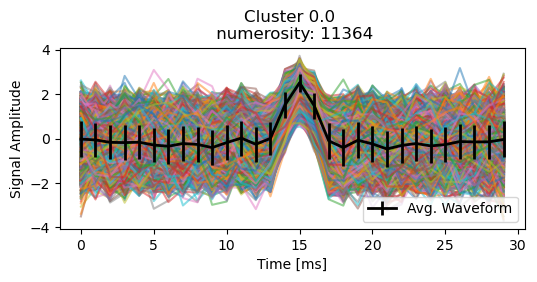

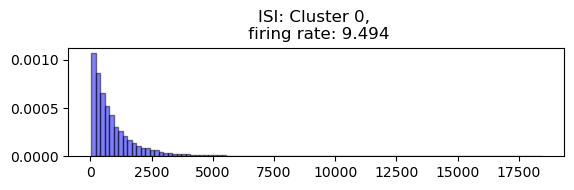

In [12]:
final_data_pos=comparative_clus(pos_cut,n_pos,merger)

In [ ]:
final_data_neg=comparative_clus(neg_cut,n_neg,merger)

Total spikes:  41679

______________________________________________________________________________________________________________


Best cluster in the range 1 to 3:  2 , with a silhouette score of:  0.4610893437122857   




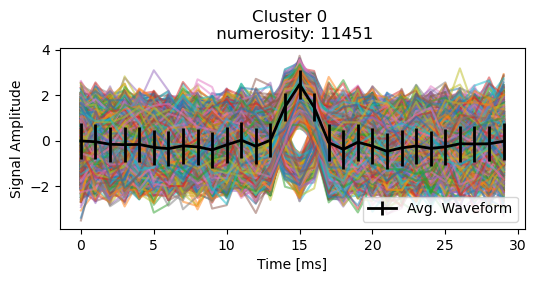

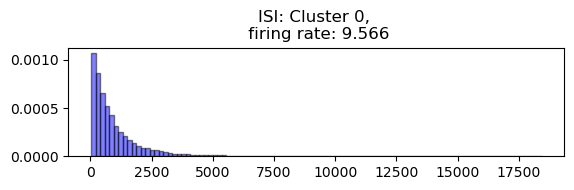

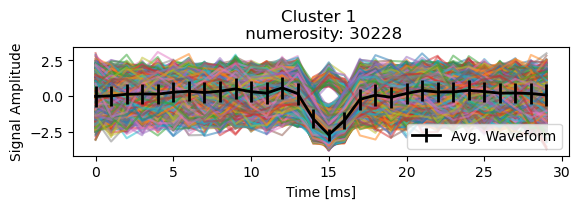

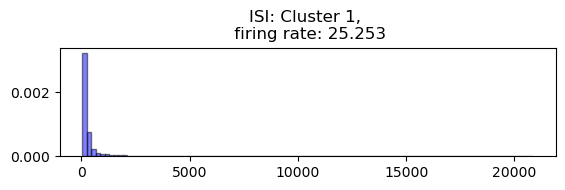

Time taken: 102.1292679309845 seconds


In [13]:
start_time = time.time()

final_data=comparative_clus(cut_outs,ind,merger)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Time taken: {elapsed_time} seconds")

In [22]:
neurons=[]
for neuron in final_data:
    neurons.append(neuron)
len(neurons)

2

In [23]:
len(neurons[1])

11452

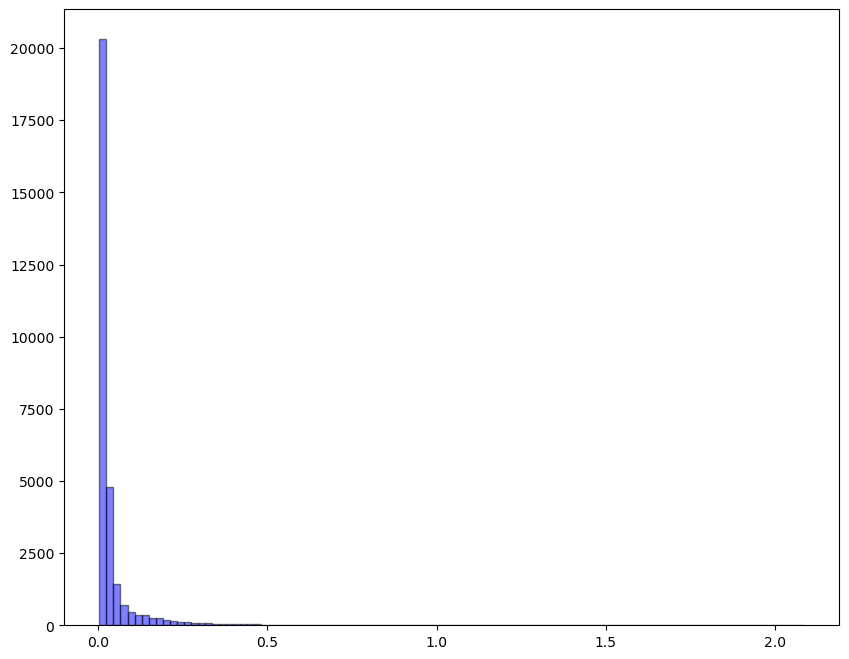

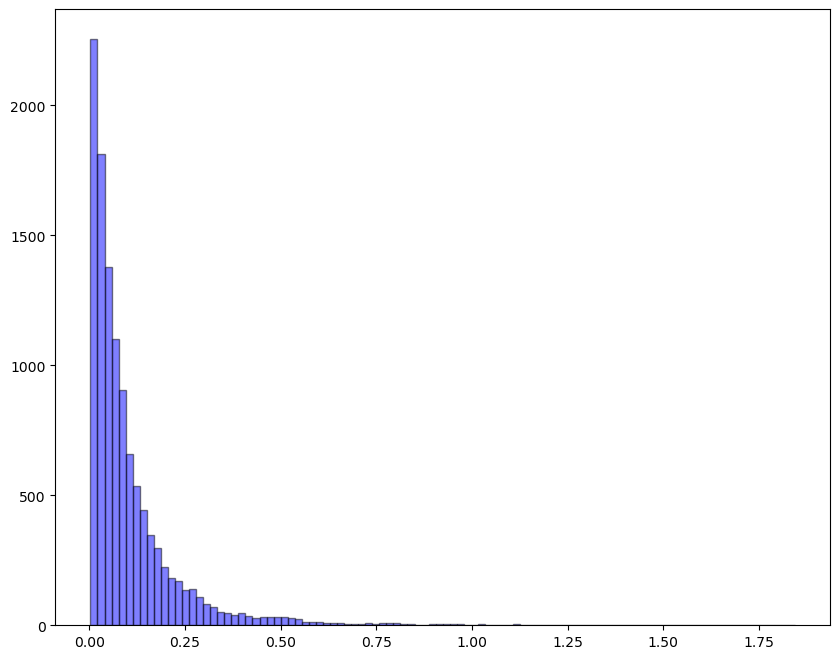

In [24]:
for neuron in neurons:
    ISI_healthy=np.diff(neuron)/10000
    fig=plt.figure(figsize=(10,8))
    plt.hist(ISI_healthy, bins=100, density=False, alpha=0.5, color='blue', edgecolor='black')
    plt.show()

In [15]:
dist=np.diff(ind)
min(dist)

30

Total spikes:  41679
labels:  [-1  0  1]
For 2 clusters, the silhouette score is: 0.39225488928263635


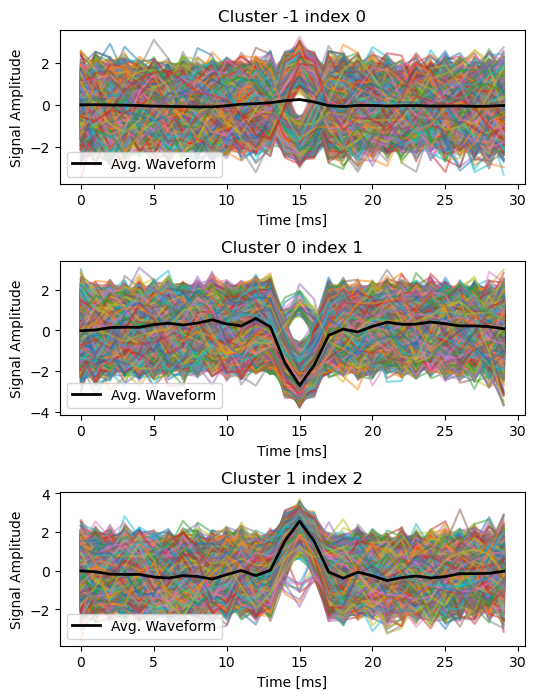

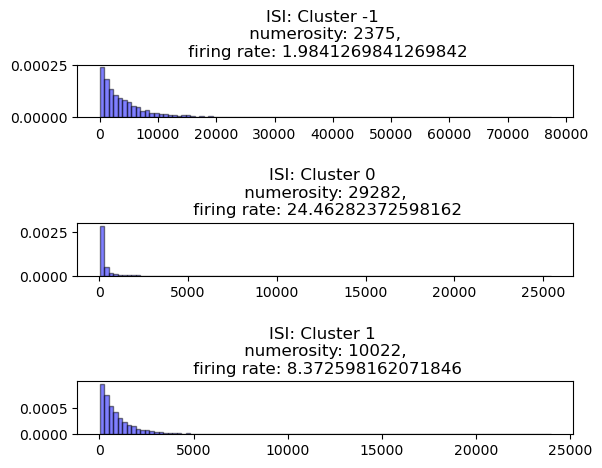

Time taken: 78.32253789901733 seconds


In [14]:
n_comp=3
mcs=15
ms=15
eps=0.1
mxcs=None
ls=60
start_time = time.time()
final_data=hdbscan_clustering(n_comp,cut_outs,ind,merger,mcs,ms,eps,mxcs,ls)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken: {elapsed_time} seconds")

(array([258., 301., 274., 245., 218., 204., 172., 193., 181., 143., 123.,
        112., 110.,  85.,  80.,  95.,  83.,  54.,  65.,  62.,  40.,  41.,
         52.,  45.,  36.,  25.,  31.,  31.,  39.,  22.,  20.,  14.,  14.,
         22.,  10.,  11.,   8.,   7.,   9.,  11.,   4.,   9.,   6.,   8.,
          9.,   3.,   7.,   7.,   3.,   6.,   6.,   4.,   6.,   1.,   3.,
          5.,   0.,   4.,   1.,   2.,   0.,   3.,   1.,   1.,   0.,   0.,
          0.,   1.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([0.003   , 0.012546, 0.022092, 0.031638, 0.041184, 0.05073 ,
        0.060276, 0.069822, 0.079368, 0.088914, 0.09846 , 0.108006,
        0.117552, 0.127098, 0.136644, 0.14619 , 0.155736, 0.165282,
        0.174828, 0.184374, 0.19392 , 0.203466, 0.213012, 0.222558,
        0.232104, 0.24165 , 0.251196, 0.260742

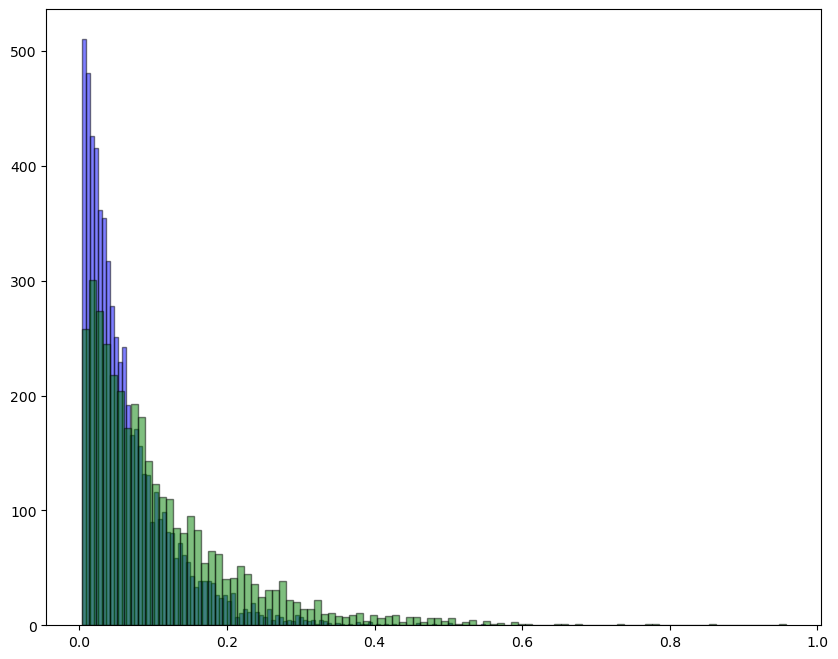

In [42]:
BL=neuron[neuron<=switch_index]
stim= neuron[(neuron > switch_index) & (neuron <= 2 * switch_index)]
post=neuron[neuron>2*switch_index]
ISI_healthy = np.diff(BL)/10000
fig=plt.figure(figsize=(10, 8))
plt.hist(ISI_healthy, bins=100, density=False, alpha=0.5, color='blue', edgecolor='black')
#plt.show()
ISI_healthy = np.diff(stim)/10000
plt.hist(ISI_healthy, bins=100, density=False, alpha=0.5, color='green', edgecolor='black')

neurons = []
for neuron in final_data_pos:
    neurons.append(neuron)
for neuron in final_data_neg:
    neurons.append(neuron)
neurons

x=randint(0,len(neurons)-1)
print('neur: ',x,len(neurons[x]))
data_healthy=neurons[x]
ISI_healthy = np.diff(data_healthy)/10000
plt.hist(ISI_healthy, bins=50, density=False, alpha=0.5, color='blue', edgecolor='black')

locs_diff=np.diff(data_healthy)
#plt.axis([-3,500,0,0.05])
plt.hist(locs_diff, bins=50, density=False, alpha=0.5, color='blue', edgecolor='black')

## Point Process

In [26]:
map_estimate,ppc_trace= Bayesian_mixture_model(ISI_healthy)

Sequential sampling (1 chains in 1 job)
NUTS: [mu1, lam1, mu2, sigma2, mu3, sigma3, w]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 225 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Sampling: [like]


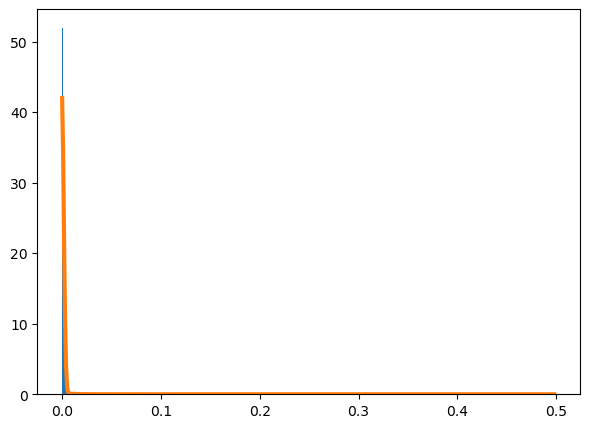

In [37]:
#with model:
#    ppc_trace = pm.sample_posterior_predictive(trace,model=model)

bins = np.arange(0, .5, 1e-3) 
plt.figure (figsize=(7,5))

hist = np.histogram(ppc_trace['posterior_predictive']['like'].values,bins=bins)
#plt.axis([-0.01,0.13,0,160])
a= plt.hist(ISI_healthy,bins)
plt.plot(hist[1][:-1],hist[0]/1000,linewidth=3);

In [38]:
lista_samples=[]
for i in list(ppc_trace['posterior_predictive']['like'].values):
    lista_samples.extend(i)

In [39]:
len(counts)
len(bins)

500

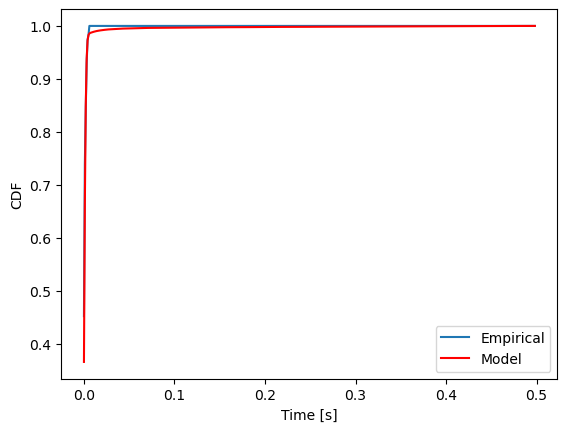

In [40]:
counts, _ = np.histogram(ISI_healthy, bins) 
prob_emp = counts / np.sum(counts)
counts, _ = np.histogram(lista_samples, bins) 
prob_model = counts / np.sum(counts)

Femp = np.cumsum(prob_emp)           
Fmodel = np.cumsum(prob_model)          
plt.figure()
plt.plot(bins[:-1], Femp)                
plt.plot(bins[:-1], Fmodel, 'r')       
#plt.xlim([0, 0.2])                  
plt.xlabel('Time [s]')
plt.ylabel('CDF')
plt.legend(['Empirical','Model'])
plt.show()

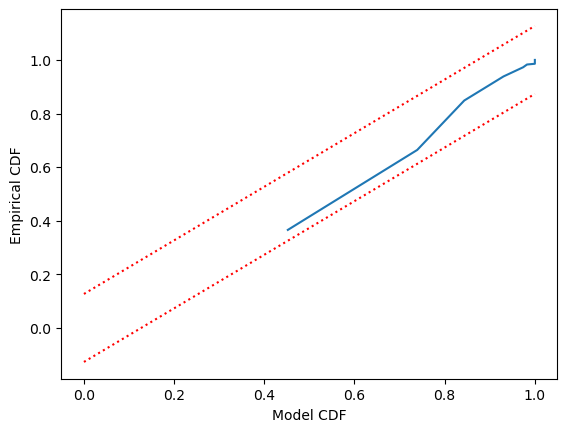

In [41]:
plt.figure()
Nlow = len(ISI_healthy)  
# Plot the confidence bounds
plt.plot([0, 1], [x + 1.36 / np.sqrt(Nlow) for x in [0, 1]], 'r:')
plt.plot([0, 1], [x - 1.36 / np.sqrt(Nlow) for x in [0, 1]], 'r:')
plt.plot(Femp, Fmodel)
#plt.axis([0, 1, 0, 1])         
plt.xlabel('Model CDF')
plt.ylabel('Empirical CDF')
plt.show()

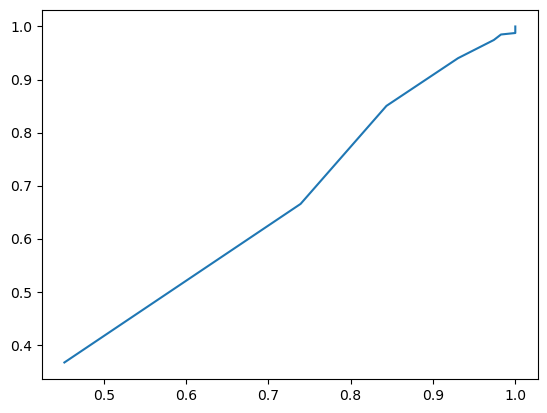

In [35]:
#plt.plot(Femp)
#plt.plot(Fmodel)
plt.plot(Femp,Fmodel)

In [ ]:
def this_Bayesian_mixture_model(ISI_data):
    with pm.Model() as model:
        ##### WALD DISTRIBUTION (INVERSE GAUSSIAN)
        mu1 = pm.Uniform('mu1',lower=0.01,upper=0.1)
        lam1 = pm.Uniform('lam1',lower=0.01,upper=0.04)
        obs1 = pm.Wald.dist(mu=mu1,lam=lam1)


        mu2 = pm.Uniform('mu2',lower=0,upper=0.2)
        sigma2 = pm.Uniform('sigma2',lower=0.0001,upper=0.5)
        obs2 = pm.TruncatedNormal.dist(mu=mu2, sigma=sigma2, lower=0.0)

        mu3 = pm.Uniform('mu3',lower=0.1,upper=0.6)
        sigma3 = pm.Uniform('sigma3',lower=0.0001,upper=0.5)
        obs3 = pm.TruncatedNormal.dist(mu=mu3, sigma=sigma3, lower=0.0)


        w = pm.Dirichlet('w', a=np.array([1., .4, .4]))
        #w = pm.Dirichlet('w', a=np.array([1., .4]))

        like = pm.Mixture('like', w=w, comp_dists = [obs1, obs2, obs3], observed=ISI_data)
        #like = pm.Mixture('like', w=w, comp_dists = [obs1, obs2], observed=ISI_data)

        step = pm.NUTS(target_accept=0.9)
        trace = pm.sample(step=step,draws=1000,chains=1,tune=1000,cores=4)
        
        ppc_trace = pm.sample_posterior_predictive(trace,model=model)
        if ppc_trace==0:
            print('ppc_trace not succesful')
        
    map_estimate = pm.find_MAP(model=model)
    
    del map_estimate['w_simplex__']
    del map_estimate['mu1_interval__']
    del map_estimate['lam1_interval__']
    del map_estimate['mu2_interval__']
    del map_estimate['sigma2_interval__']
    del map_estimate['mu3_interval__']
    del map_estimate['sigma3_interval__']
    
    map_estimate['w1'] = map_estimate['w'][0]
    map_estimate['w2'] = map_estimate['w'][1]
    map_estimate['w3'] = map_estimate['w'][2]

    del map_estimate['w']


    return map_estimate, ppc_trace

In [ ]:
dataframe = pd.DataFrame()
list_neurons = adj_neur
counter=0
print('Original number of neurons: ',len(list_neurons))
for neuron in list_neurons:
    neuron=neuron[neuron>0*10000]
    neuron=neuron[neuron<200*10000]
    print('  Neuron with ',neuron.shape[0],'spikes')
    if neuron.shape[0]>1000:

        counter+=1
    else:
        print('    Excluded neuron with n spikes = ',neuron.shape[0])
        continue

    ISI_healthy = np.diff(neuron)/10000


    map_estimate = Bayesian_mixture_model(ISI_healthy)

    df = pd.DataFrame.from_dict(map_estimate,orient='index')
    dataframe = pd.concat([dataframe,df],axis = 1)
print('Final number of neurons: ',counter)
print('Target = ',target)

In [ ]:
final = dataframe.T
final.to_csv('Data after PP/DataAfter')

## Classification

In [ ]:
def performance_visualizer(trials_obj,n_models,choice=False,**choice_var):
    
    import pandas as pd
    
    performance = [1-t['result']['loss'] for t in trials_obj.trials]
    
    
    hyperparam= list(trials_obj.trials[0]['misc']['vals'].keys())
    
    values_dict ={}
    
    for i in hyperparam:
        
        values_dict[i]=[]
        
        for j in trials_obj.trials:
            
            if(len(j['misc']['vals'][i])==0):
                
                values_dict[i].append(np.NaN)
                
            else:
            
                values_dict[i].append(j['misc']['vals'][i][0])
                
    out = pd.DataFrame.from_dict(values_dict)
    
    out['performance'] = performance
    
    out=out.sort_values(by=['performance'])
    
    
    if choice:
        
        for i in list(choice_var.keys()):
        
            for j,_ in enumerate(choice_var[i]):
        
                out[i]=out[i].replace(j,choice_var[i][j])
    
    return out.tail(n_models)

In [ ]:
dataset = pd.read_csv('Data after PP/Data')
dataset = dataset.drop(['Unnamed: 0'],axis=1)
dataset